In [39]:
#公式：N日BIAS= (當日收盤價-N日移動平均價)/N日移動平均價
#乖離率這項指標的原理就如同「物極必反」的概念一樣，股價與均線距離越遠，代表乖離率越大，股價隨時都有可能反轉回歸到基本軌道。
from mongo import Mongo
repo = Mongo(db='trading_bot', collection='stock_price')
import matplotlib.pyplot as plt


In [33]:
df = repo.get_data_by_stock_id('1101')
selected_columns = ['Timestamp', 'close']
close = df[selected_columns].set_index('Timestamp')

In [34]:
close

,close
Timestamp,
2013-01-02,39.00
2013-01-03,38.85
2013-01-04,39.00
2013-01-07,38.90
2013-01-08,38.50
...,...
2023-05-26,38.00
2023-05-29,38.15
2023-05-30,38.30


In [10]:
close.rolling(30).mean().iloc[30]

nan

In [28]:
thirty_day_bias = (close[30:] - close.rolling(30).mean()) / close.rolling(30).mean()

<Axes: xlabel='Timestamp'>

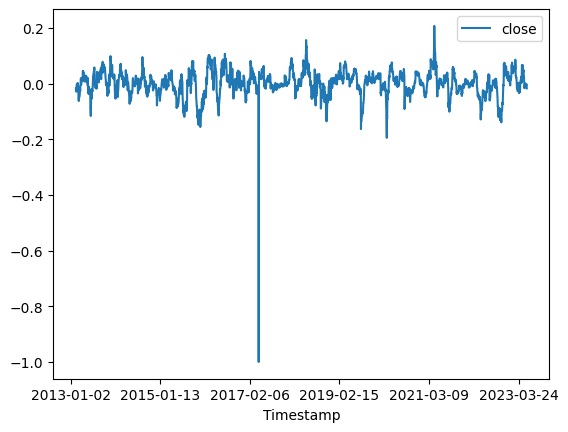

In [30]:
thirty_day_bias.plot()

In [74]:
def get_price_bias_ratio(repo=repo,stock_id='1101', rolling=30):
    df = repo.get_data_by_stock_id(stock_id=stock_id)
    selected_columns = ['Timestamp', 'close']
    close = df[selected_columns].set_index('Timestamp')
    price_bias_ratio = (close[rolling:] - close.rolling(rolling).mean()) / close.rolling(rolling).mean()
    price_bias_ratio.dropna(inplace=True)
    return price_bias_ratio
    
    


In [69]:


# fig,ax = plt.subplots(figsize=(15,10))
bias_ratio= get_price_bias_ratio(stock_id='1102', rolling=30)

# positive_average_bias = bias_ratio
# average_bias

average_positive_bias = bias_ratio[bias_ratio>0]

average_negative_bias = bias_ratio[bias_ratio<0]
average_negative_bias
print(f' positive :{average_positive_bias}')
print(f' negative :{average_negative_bias}')

buy = bias_ratio[bias_ratio> average_negative_bias]
sell = bias_ratio[bias_ratio> average_positive_bias]



 positive :               close
Timestamp           
2013-02-22       NaN
2013-02-23       NaN
2013-02-25       NaN
2013-02-26       NaN
2013-02-27  0.003118
...              ...
2023-05-26       NaN
2023-05-29       NaN
2023-05-30       NaN
2023-05-31       NaN
2023-06-01       NaN

[2516 rows x 1 columns]
 negative :               close
Timestamp           
2013-02-22 -0.010111
2013-02-23 -0.000090
2013-02-25 -0.005061
2013-02-26 -0.002169
2013-02-27       NaN
...              ...
2023-05-26 -0.003933
2023-05-29 -0.005218
2023-05-30 -0.000907
2023-05-31 -0.003439
2023-06-01 -0.001737

[2516 rows x 1 columns]


Index(['2013-02-22', '2013-02-23', '2013-02-25', '2013-02-26', '2013-02-27',
       '2013-03-01', '2013-03-04', '2013-03-05', '2013-03-06', '2013-03-07',
       ...
       '2023-05-19', '2023-05-22', '2023-05-23', '2023-05-24', '2023-05-25',
       '2023-05-26', '2023-05-29', '2023-05-30', '2023-05-31', '2023-06-01'],
      dtype='object', name='Timestamp', length=2516)

TypeError: get_price_bias_ratio() missing 1 required positional argument: 'repo'

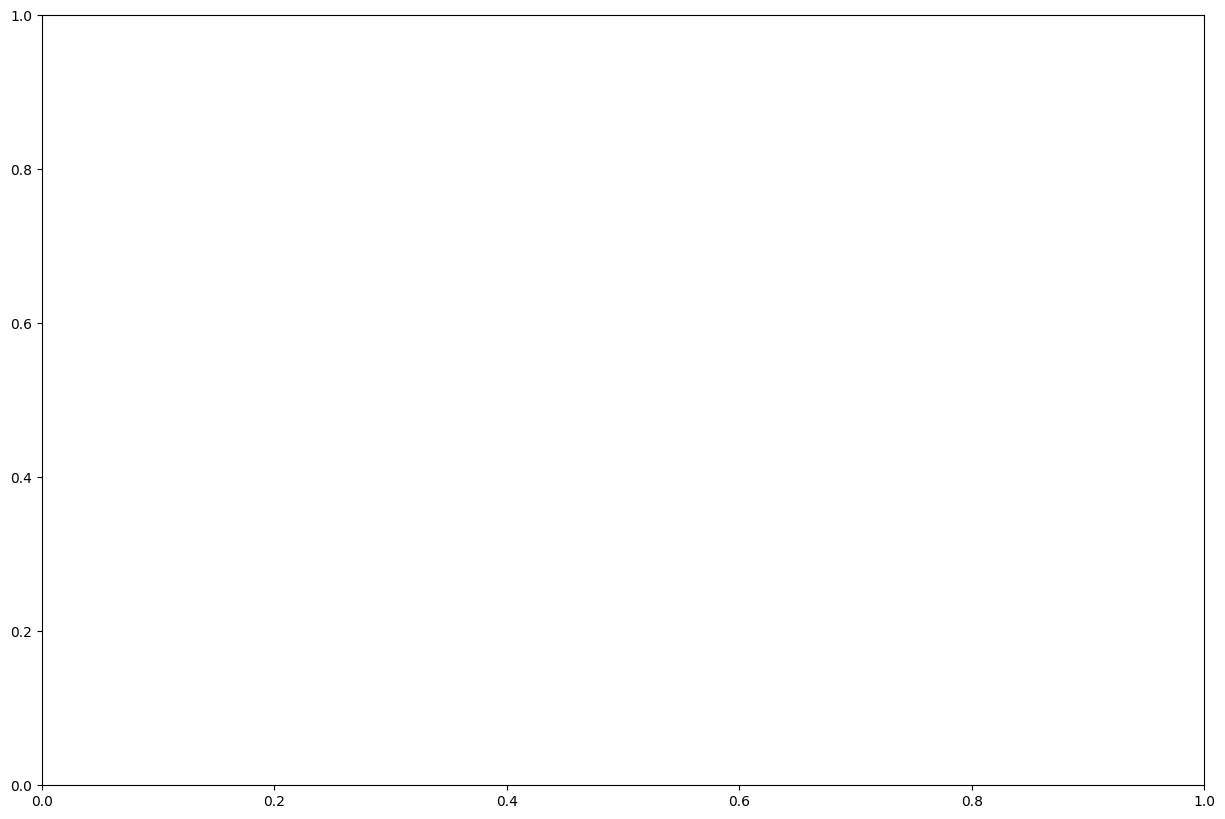

In [78]:
import matplotlib.pyplot as plt
import pandas as pd

# Assuming get_price_bias_ratio is a defined function

# Plot settings
fig, ax = plt.subplots(figsize=(15,10))

# Get bias ratio
bias_ratio= get_price_bias_ratio(stock_id='1101', rolling=30)

# Separate positive and negative bias
average_positive_bias = bias_ratio[bias_ratio > 0].mean()
average_negative_bias = bias_ratio[bias_ratio < 0].mean()

print(f'Average positive bias: {average_positive_bias}')
print(f'Average negative bias: {average_negative_bias}')

# Create buy and sell signals based on averages
buy = bias_ratio[bias_ratio > average_negative_bias]
sell = bias_ratio[bias_ratio < average_positive_bias]

# Assuming that we want to plot the buy and sell signals on the graph
ax.plot(bias_ratio.index, bias_ratio, label='Bias Ratio')
ax.scatter(buy.index, buy, color='g', label='Buy Signal')
ax.scatter(sell.index, sell, color='r', label='Sell Signal')

ax.legend()

plt.show()


#calculate the return using price
df = repo.get_data_by_stock_id('1101')
selected_columns = ['Timestamp', 'close']
close = df[selected_columns].set_index('Timestamp')



/Users/max/Library/Python/3.11/lib/python/site-packages/numpy/core/fromnumeric.py:57: RuntimeWarning: invalid value encountered in accumulate
  return bound(*args, **kwds)


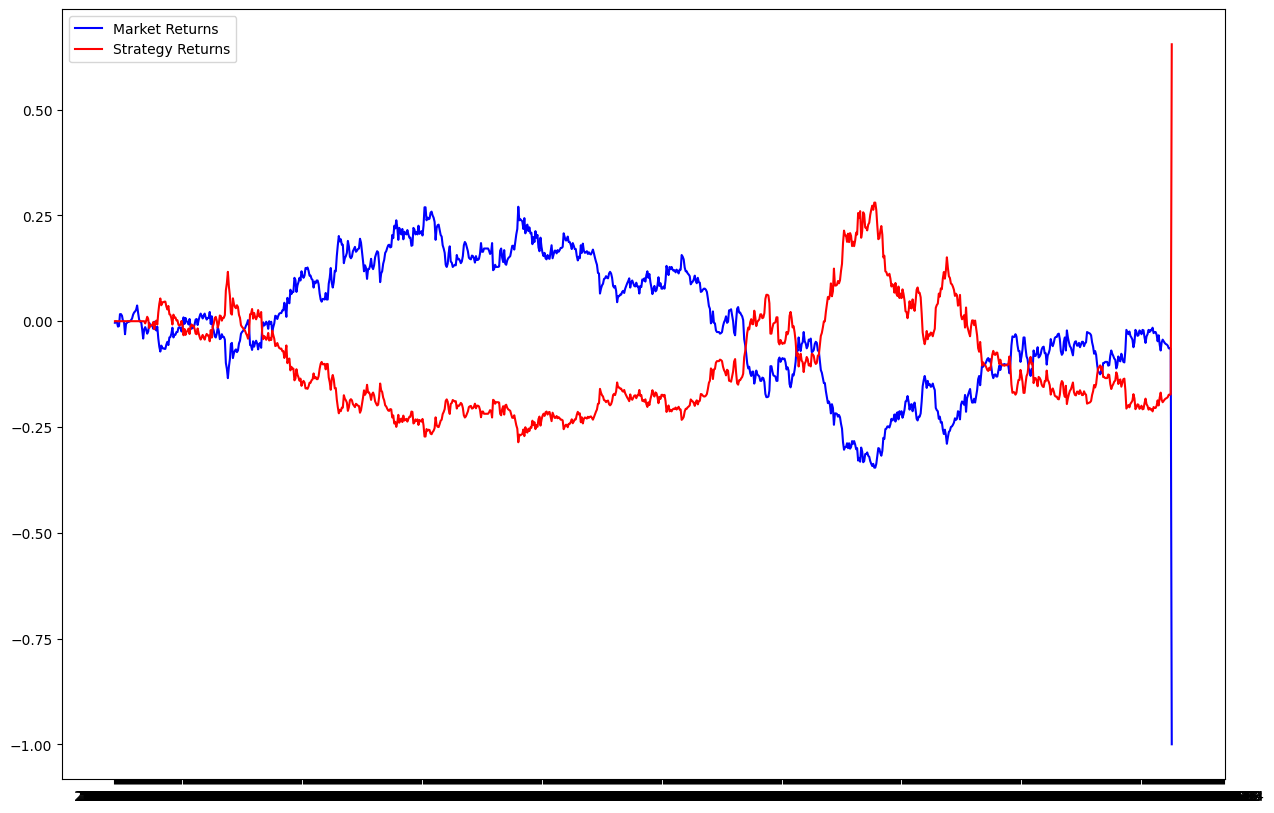

In [79]:
# Define signals
close['Signal'] = 0.0
close['Signal'].loc[buy.index] = 1.0
close['Signal'].loc[sell.index] = -1.0

# Shift the signals to obtain positions on the next day (due to transaction time delay)
close['Position'] = close['Signal'].shift()

# Calculate the daily market returns and strategy returns
close['Market_Returns'] = close['close'].pct_change()
close['Strategy_Returns'] = close['Market_Returns'] * close['Position']

# Calculate the cumulative market and strategy returns
close['Cumulative_Market_Returns'] = (1 + close['Market_Returns']).cumprod() - 1
close['Cumulative_Strategy_Returns'] = (1 + close['Strategy_Returns']).cumprod() - 1

# Plot cumulative strategy returns and market returns
fig, ax = plt.subplots(figsize=(15,10))
ax.plot(close['Cumulative_Market_Returns'], color='b', label='Market Returns')
ax.plot(close['Cumulative_Strategy_Returns'], color='r', label='Strategy Returns')
ax.legend()
plt.show()


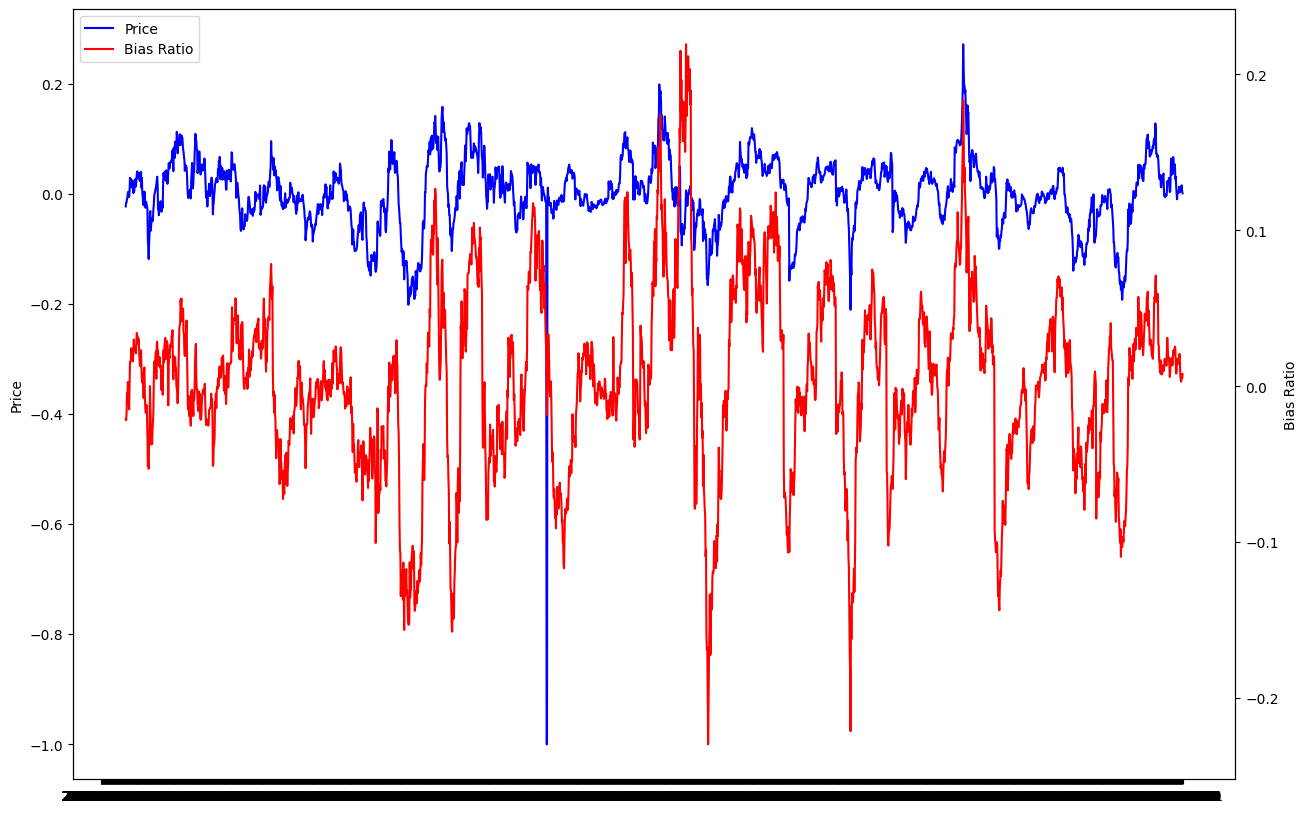

In [77]:
import matplotlib.pyplot as plt

def get_price_bias_ratio(repo, stock_id='1101', rolling=60):
    df = repo.get_data_by_stock_id(stock_id=stock_id)
    selected_columns = ['Timestamp', 'close']
    close = df[selected_columns].set_index('Timestamp')
    price_bias = (close - close.rolling(rolling).mean()) / close.rolling(rolling).mean()
    return price_bias

fig, ax1 = plt.subplots(figsize=(15 ,10))
ax2 = ax1.twinx()  # Create a second y-axis that shares the same x-axis

# Plotting price on the first y-axis
price_data = get_price_bias_ratio(repo, stock_id='1101', rolling=60)['close']
ax1.plot(price_data, color='blue', label='Price')
ax1.set_ylabel('Price')

# Plotting bias ratio on the second y-axis
bias_data = get_price_bias_ratio(repo, stock_id='1102', rolling=60)
ax2.plot(bias_data, color='red', label='Bias Ratio')
ax2.set_ylabel('Bias Ratio')

# Add legends
lines = ax1.get_lines() + ax2.get_lines()
labels = [line.get_label() for line in lines]
ax1.legend(lines, labels, loc='upper left')

plt.show()